In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('gdrive/My Drive/DeepAverageNetwork/')

!pip install datasets

!pip install -r requirements.txt

Mounted at /content/gdrive
     |████████████████████████████████| 306 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 44.3 MB/s 
     |████████████████████████████████| 243 kB 51.7 MB/s 
     |████████████████████████████████| 132 kB 51.8 MB/s 
     |████████████████████████████████| 61 kB 500 kB/s 
     |████████████████████████████████| 271 kB 50.9 MB/s 
     |████████████████████████████████| 160 kB 48.8 MB/s 
     |████████████████████████████████| 192 kB 47.3 MB/s 
     |████████████████████████████████| 831.4 MB 6.6 kB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 11.5 MB 19.4 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 2.6 MB 43.0 MB/s 
     |████████████████████████████████| 1.5 MB 45.6 MB/s 
     |████████████████████████████████| 285 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 596 kB 5

In [2]:
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip  "wiki-news-300d-1M.vec.zip" -d "."

--2021-12-28 02:40:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  10.4MB/s    in 64s     

2021-12-28 02:41:35 (10.1 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: ./wiki-news-300d-1M.vec  


In [3]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm


import matplotlib.pyplot as plt  

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [4]:
num_tokens = 100_000

In [5]:
def load_embeddings(path, pad_token='PAD', unk_token='UNK', num_tokens=100_000):
    """
    token2index: Dict[str, int]
    embeddings_matrix: np.array
    """
    
    token2index = dict()
    
    with open(path, encoding='utf-8') as f:
        vocab_size, embedding_dim = f.readline().strip().split()
        vocab_size, embedding_dim = int(vocab_size), int(embedding_dim)
         
        progress_bar = tqdm(total=num_tokens, desc='Reading embeddings file')
        embeddings_matrix = np.zeros((num_tokens, embedding_dim))
        
        token2index[pad_token] = 0
        embeddings_matrix[len(token2index):, ] = np.zeros(embedding_dim)

        token2index[unk_token] = 1
        embeddings_matrix[len(token2index):, ] = np.ones(embedding_dim)
        
        for line in f:            
                parts = line.strip().split()
                token = ' '.join(parts[:-embedding_dim]).lower()

                if token in token2index:
                    continue

                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                token2index[token] = len(token2index)
                embeddings_matrix[len(token2index):, ] = word_vector

                progress_bar.update()
                if len(token2index) == num_tokens:
                    break
        progress_bar.close()
    
    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

In [6]:
token2index, embeddings_matrix = load_embeddings('wiki-news-300d-1M.vec', num_tokens=num_tokens)

Reading embeddings file: 100%|█████████▉| 99998/100000 [38:52<00:00, 42.88it/s]  


## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [7]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [8]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [9]:
for batch in train_loader:
    break

batch

{'label': tensor([2, 2]),
 'text': ['Oneil\\u2019s Barber & Beauty will be open Monday @ 10am and not closing to the last person leave!  #WeGrind',
  '"Okay so I\'m going to be able to cross off 3 Legend bands/artist from my Bucket List.. AC/DC, Paul McCartney and tomorrow Metallica! #Legends"']}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [10]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [11]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [12]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [13]:
def empty_collate(batch):
    return batch

In [14]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [15]:
for batch in train_loader:
    break

batch

[{'label': 1,
  'text': "There's only one Minister in Harper's pantheon, and he's 100% Prime... (May contain Antibiotics, HGH, GMO...)"},
 {'label': 0,
  'text': 'Well fuck. My sleep schedule is not ideal for the SATs tomorrow'}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [16]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        indexed_tokens = [self.token2index[token] if token in self.token2index else \
                          self.unk_index for token in tokenized_text]
        return indexed_tokens
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        res = []
        counter = 0
        for i, token in enumerate(tokens_indices):
            if i < self.max_length:
                if token == self.unk_index and counter == 0:
                    res.append(token)
                    counter = counter + 1
                elif token == self.unk_index and counter != 0:
                    continue
                else:
                    res.append(token)
                    
        if len(res) < self.max_length:
            res.extend([self.pad_index] * (self.max_length - len(res)-1))
            
        return res 
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        return self.padding(self.indexing(self.tokenize(text)))  
    
        
    def collate(self, batch):
        
        tokenized_texts = []
        labels = []
        
        for sample in batch:
            label = sample["label"]
            text = sample["text"]
            tokenized_texts.append(self(text))
            labels.append(label)

        tokenized_texts = torch.tensor(tokenized_texts)
        labels = torch.tensor(labels)
        
        return tokenized_texts, labels

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [17]:
max_length=64

collator = Tokenizer(base_tokenizer=ToktokTokenizer(), 
              token2index=token2index, 
              pad_token='PAD', 
              unk_token ='UNK', 
              max_length = max_length
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collator.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, collate_fn=collator.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collator.collate)

In [18]:
for x, y in train_loader:
    break

In [19]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрал метрику f1
Почему я выбрал эту метрику:  
<РАССКАЗ_ПРО_МЕТРИКУ>

Выбрал f-1 - стандартную метрику для баланса между точностью и полнотой.

In [20]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, vocab_size: int, embedding_dim: int, embeddings_weights: np.array, lin_1_out: int, output_dim: int, max_len: int, dropout: float):
        
        super(DeepAverageNetwork, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(embeddings_weights), freeze=True)
        self.batch_norm = nn.BatchNorm1d(embedding_dim)
        self.linear_1 = torch.nn.Linear(in_features=embedding_dim, out_features=lin_1_out)
        self.non_linear_function = torch.nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = torch.nn.Linear(in_features=lin_1_out, out_features=output_dim)

    def forward(self, text: List[int]) -> torch.Tensor:
        
        embedded = self.embedding(text)
        hidden = torch.mean(embedded, dim=1)
        batch_norm = self.batch_norm(hidden)
        lin1_outputs = self.linear_1(batch_norm)
        non_lin_out = self.non_linear_function(lin1_outputs)
        dropout = self.dropout(non_lin_out)
        lin2_outputs = self.linear_2(dropout)
        
        return lin2_outputs

In [21]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in tqdm(enumerate(iterator), total=len(iterator)):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze() 
        loss = criterion(predictions, ys.to(device))        

        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="weighted"))
        
    return np.mean(epoch_f1), np.mean(epoch_loss)


def evaluate(model, iterator, criterion):
    epoch_loss = []
    epoch_f1 = []
    model.eval() 
    with torch.no_grad():
        for texts, ys in tqdm(iterator, total=len(iterator)):   
            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="weighted"))
            
    return np.mean(epoch_f1), np.mean(epoch_loss) 

In [22]:
model = DeepAverageNetwork(
    vocab_size=num_tokens,
    embedding_dim=len(embeddings_matrix[0]),
    embeddings_weights=embeddings_matrix,
    output_dim=3,
    max_len=max_length,
    dropout=0.2,
    lin_1_out=32
    )

In [23]:
model

DeepAverageNetwork(
  (embedding): Embedding(100000, 300)
  (batch_norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_1): Linear(in_features=300, out_features=32, bias=True)
  (non_linear_function): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=32, out_features=3, bias=True)
)

## Задайте функцию потерь и оптимизатор

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

## Сделайте цикл обучения

In [25]:
NUM_EPOCHS = 30

train_losses = []
val_losses = []

train_f1 = []
val_f1 = []

for n_epoch in range(NUM_EPOCHS):
    print(n_epoch)
    f1_train, loss_train = train(model=model, iterator=train_loader, optimizer=optimizer, criterion=criterion)
    train_f1.append(f1_train)
    train_losses.append(loss_train)

    f1_valid, loss_valid = evaluate(model=model, iterator=valid_loader, criterion=criterion)
    val_f1.append(f1_valid)
    val_losses.append(loss_valid)
    print(f'Train loss: {loss_train}, Train f1: {f1_train}\nValid loss: {loss_valid}, Valid f1: {f1_valid}')
    print('                             ')

0


100%|██████████| 16/16 [00:00<00:00, 38.47it/s]


Train loss: 1.021643841300024, Train f1: 0.4342582003962915
Valid loss: 0.9951023645699024, Valid f1: 0.4477153405900943
                             
1


100%|██████████| 16/16 [00:00<00:00, 39.90it/s]


Train loss: 0.9781844931490281, Train f1: 0.47876552073920836
Valid loss: 0.9743334874510765, Valid f1: 0.46546614075753145
                             
2


100%|██████████| 16/16 [00:00<00:00, 39.51it/s]


Train loss: 0.9526301924587965, Train f1: 0.49523088279711447
Valid loss: 0.9522312544286251, Valid f1: 0.4869773087430307
                             
3


100%|██████████| 16/16 [00:00<00:00, 41.42it/s]


Train loss: 0.9315776384177328, Train f1: 0.5109307166665827
Valid loss: 0.9402463026344776, Valid f1: 0.4948506388695304
                             
4


100%|██████████| 16/16 [00:00<00:00, 39.92it/s]


Train loss: 0.91520182024531, Train f1: 0.5247312974660094
Valid loss: 0.9275189004838467, Valid f1: 0.512338590708993
                             
5


100%|██████████| 16/16 [00:00<00:00, 37.95it/s]


Train loss: 0.8991681521012336, Train f1: 0.5367649490064933
Valid loss: 0.9177856557071209, Valid f1: 0.5185666263157673
                             
6


100%|██████████| 16/16 [00:00<00:00, 40.45it/s]


Train loss: 0.8883206131411534, Train f1: 0.5471446587422374
Valid loss: 0.9057172387838364, Valid f1: 0.5336417288025046
                             
7


100%|██████████| 16/16 [00:00<00:00, 40.56it/s]


Train loss: 0.8768951812712085, Train f1: 0.5533593251266057
Valid loss: 0.9012637212872505, Valid f1: 0.5433665299469729
                             
8


100%|██████████| 16/16 [00:00<00:00, 39.71it/s]


Train loss: 0.8659587412321267, Train f1: 0.5626236333040646
Valid loss: 0.897559117525816, Valid f1: 0.5418584949633132
                             
9


100%|██████████| 16/16 [00:00<00:00, 36.67it/s]


Train loss: 0.8552315687598968, Train f1: 0.5718159433344516
Valid loss: 0.8902488201856613, Valid f1: 0.5470619739582572
                             
10


100%|██████████| 16/16 [00:00<00:00, 38.98it/s]


Train loss: 0.8474730335029901, Train f1: 0.5798040970916659
Valid loss: 0.8845287337899208, Valid f1: 0.5496641963374262
                             
11


100%|██████████| 16/16 [00:00<00:00, 39.72it/s]


Train loss: 0.8389798766758596, Train f1: 0.5872837530782228
Valid loss: 0.8810054361820221, Valid f1: 0.5586272231455602
                             
12


100%|██████████| 16/16 [00:00<00:00, 39.16it/s]


Train loss: 0.8302525206774223, Train f1: 0.5935874913308
Valid loss: 0.8715620264410973, Valid f1: 0.5651719442379989
                             
13


100%|██████████| 16/16 [00:00<00:00, 39.59it/s]


Train loss: 0.8217838399884414, Train f1: 0.6012623464354055
Valid loss: 0.8698912411928177, Valid f1: 0.5627557378072094
                             
14


100%|██████████| 16/16 [00:00<00:00, 38.97it/s]


Train loss: 0.8136320154206091, Train f1: 0.6074841086161888
Valid loss: 0.8642096631228924, Valid f1: 0.5708092196127743
                             
15


100%|██████████| 16/16 [00:00<00:00, 39.87it/s]


Train loss: 0.8065932561703423, Train f1: 0.6114463463127411
Valid loss: 0.8619505576789379, Valid f1: 0.5733520982356115
                             
16


100%|██████████| 16/16 [00:00<00:00, 40.53it/s]


Train loss: 0.7992707996809182, Train f1: 0.6178785991854728
Valid loss: 0.8570303656160831, Valid f1: 0.5743595398097328
                             
17


100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Train loss: 0.7914919641171517, Train f1: 0.6236698840326158
Valid loss: 0.8574512116611004, Valid f1: 0.5818259575589577
                             
18


100%|██████████| 16/16 [00:00<00:00, 39.34it/s]


Train loss: 0.7848730925418416, Train f1: 0.6275388193281182
Valid loss: 0.8530189618468285, Valid f1: 0.578976113748846
                             
19


100%|██████████| 16/16 [00:00<00:00, 40.53it/s]


Train loss: 0.7775506789610833, Train f1: 0.6336964373809525
Valid loss: 0.8510017581284046, Valid f1: 0.5853958998654751
                             
20


100%|██████████| 16/16 [00:00<00:00, 36.78it/s]


Train loss: 0.7700542897737327, Train f1: 0.6383526959530857
Valid loss: 0.8448246382176876, Valid f1: 0.5846345429962823
                             
21


100%|██████████| 16/16 [00:00<00:00, 39.34it/s]


Train loss: 0.7642291558890784, Train f1: 0.6446972096878273
Valid loss: 0.8494075164198875, Valid f1: 0.5875529765065955
                             
22


100%|██████████| 16/16 [00:00<00:00, 37.31it/s]


Train loss: 0.7573317399545878, Train f1: 0.648311678437994
Valid loss: 0.8408294022083282, Valid f1: 0.588463951909743
                             
23


100%|██████████| 16/16 [00:00<00:00, 38.80it/s]


Train loss: 0.7508571383332004, Train f1: 0.6527629292395428
Valid loss: 0.8423597663640976, Valid f1: 0.5918320170021342
                             
24


100%|██████████| 16/16 [00:00<00:00, 39.16it/s]


Train loss: 0.7442360133016143, Train f1: 0.6584891029838867
Valid loss: 0.8346039354801178, Valid f1: 0.5882208961641142
                             
25


100%|██████████| 16/16 [00:00<00:00, 40.54it/s]


Train loss: 0.7380976274567825, Train f1: 0.6615790475225533
Valid loss: 0.8370529301464558, Valid f1: 0.5937802952564375
                             
26


100%|██████████| 16/16 [00:00<00:00, 38.71it/s]


Train loss: 0.7342558079073075, Train f1: 0.6638552239870489
Valid loss: 0.8347308151423931, Valid f1: 0.5895875249371537
                             
27


100%|██████████| 16/16 [00:00<00:00, 38.92it/s]


Train loss: 0.7253003674728864, Train f1: 0.6683155801585261
Valid loss: 0.8378701396286488, Valid f1: 0.5959240126011336
                             
28


100%|██████████| 16/16 [00:00<00:00, 40.59it/s]


Train loss: 0.7190312541165605, Train f1: 0.6720775624413978
Valid loss: 0.8377260155975819, Valid f1: 0.5948568085410989
                             
29


100%|██████████| 16/16 [00:00<00:00, 40.38it/s]

Train loss: 0.7140191955392768, Train f1: 0.6762738200835163
Valid loss: 0.8367057256400585, Valid f1: 0.5935701749409075
                             


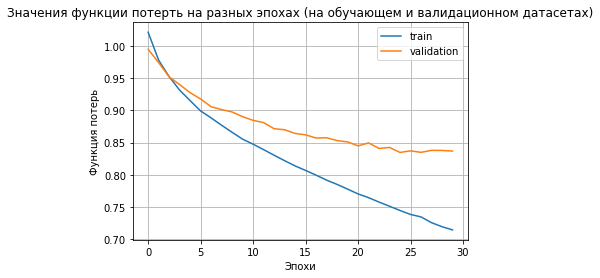

In [26]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Значения функции потерть на разных эпохах (на обучающем и валидационном датасетах)')
plt.ylabel('Функция потерь')
plt.xlabel('Эпохи')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

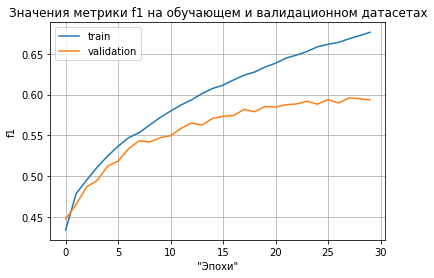

In [27]:
plt.plot(train_f1)
plt.plot(val_f1)
plt.title('Значения метрики f1 на обучающем и валидационном датасетах')
plt.ylabel('f1')
plt.xlabel('"Эпохи"')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

In [28]:
def evaluation(model, iterator, criterion):
    _preds = []
    _true = []
    model.eval()  
    with torch.no_grad():
        for texts, ys in tqdm(iterator, total=len(iterator)):   
            predictions = model(texts.to(device)).squeeze()         
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            _preds.extend(preds)
            _true.extend(y_true)
    return _true, _preds

In [29]:
true, preds = evaluation(model=model, iterator=test_loader, criterion=criterion)

100%|██████████| 96/96 [00:02<00:00, 41.68it/s]


In [30]:
assert len(true) == len(preds)

In [31]:
print(classification_report(y_true=true, y_pred=preds))

              precision    recall  f1-score   support

           0       0.64      0.30      0.41      3972
           1       0.57      0.70      0.63      5937
           2       0.43      0.58      0.49      2375

    accuracy                           0.54     12284
   macro avg       0.54      0.52      0.51     12284
weighted avg       0.56      0.54      0.53     12284



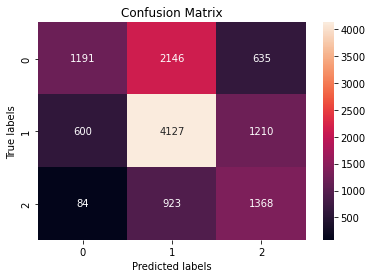

In [32]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_true=true, y_pred=preds), annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Подход целиком базируется на идее о том, что среднее эмбеддингов слов в предложении - это приближение эмбеддинга целого предложения, которая хоть и имеет право на существование, является достаточно грубой и уступающей по эффективности современным представлениям предложений.

Далеко не всегда она выступает лучше логистической регрессии с TFIDF-весами слов, поэтому я бы не использовал ее в качестве моего первого варианта.

Дальнейшие улучшения - подбор оптимального корпуса эмбеддингов, настройка гиперпараметров, добавление свертки к сетке.